In [60]:
import pandas as pd
import swifter
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier



from sklearn.ensemble import RandomForestClassifier


sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 5]


In [2]:
df = pd.read_csv("./Data/Part 1 - Telemarketing.csv")

In [3]:
df = pd.concat([df, pd.get_dummies(df.outcome, prefix='outcome').astype(int)], axis=1)
df = pd.concat([df, pd.get_dummies(df.prev_outcome, prefix='prev_outcome').astype(int)], axis=1)

## Exercise 1: inspecting the data

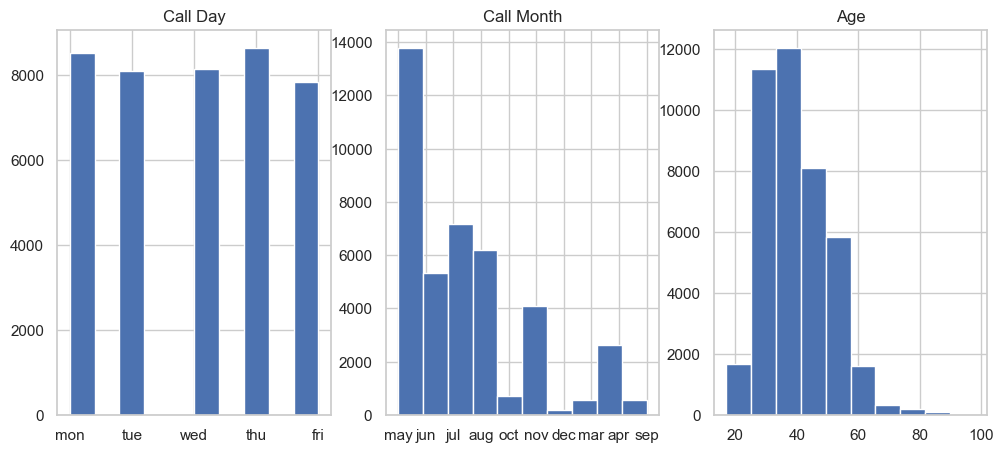

In [4]:
descriptives = df.describe(include='all')

summary_stats = {
    'total_calls': len(df),
    'success_rate': descriptives.outcome_yes['mean'],
    'age_mean': descriptives.age['mean'],
    'age_min': descriptives.age['min'],
    'age_max': descriptives.age['max'],
    'top_day': descriptives.call_day['top'],
    'top_month': descriptives.call_month['top'],
}


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
df.call_day.hist(ax=ax1)
ax1.set_title('Call Day')
df.call_month.hist(ax=ax2)
ax2.set_title('Call Month')
df.age.hist(ax=ax3)
ax3.set_title('Age')
plt.show()



In [5]:
pd.DataFrame(summary_stats.values(), index=summary_stats.keys(), columns=['Value'])


,Value
total_calls,41188
success_rate,0.112654
age_mean,40.02406
age_min,17.0
age_max,98.0
top_day,thu
top_month,may


What additional variables would you like to have about the client, the phone call, or other details
for performing this analysis? Why? Describe your answer briefly (max 100 words).

Call duration - To analyze if longer conversations correlate with success
Time of day - Customer availability patterns could vary significantly
Number of products already owned - Existing relationship depth might affect success
Income level - Financial capacity could influence purchase decisions
Last contact date - Frequency of contact might impact response

## Exercise 2: complete decision tree

Test Accuracy: 0.8386

Confusion Matrix (Test Data):


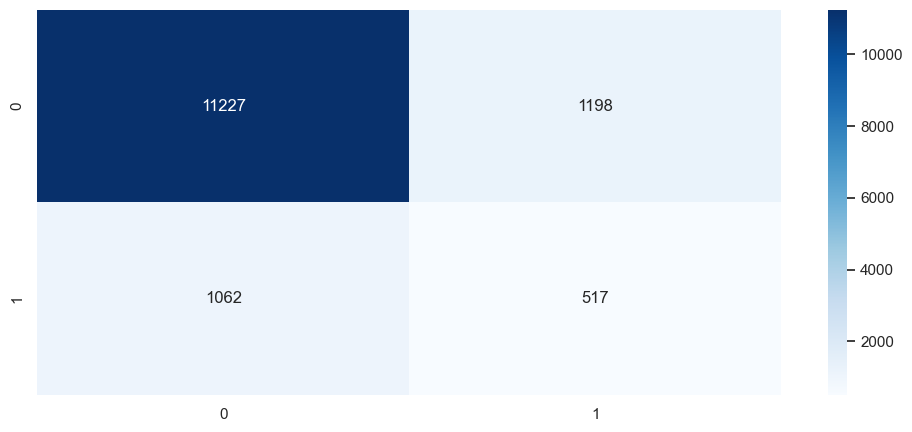

Number of nodes: 8873
Number of leaves: 4437
Tree depth: 40


In [6]:
numeric_selector = make_column_selector(dtype_include=['int64', 'float64'])
categorical_selector = make_column_selector(dtype_include=['object', 'category'])

# Create preprocessor that handles both types automatically
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_selector),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_selector)
])

dummy_columns = [col for col in df.columns if 'outcome_' in col or 'prev_outcome_' in col]

X = df.drop(['outcome', *dummy_columns], axis=1)
y = df['outcome_yes']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=42)

# Create the model
model = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(
        min_samples_leaf=1,
        max_depth=None,
        ccp_alpha=0.0
    )
)

# Fit the model
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions for the test set
y_test_pred = model.predict(X_test)

# Calculate the confusion matrix for the test set
print("\nConfusion Matrix (Test Data):")
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.show()


tree = model[-1]  # Get the tree from pipeline

# Print tree statistics
print(f"Number of nodes: {tree.tree_.node_count}")
print(f"Number of leaves: {tree.get_n_leaves()}")
print(f"Tree depth: {tree.get_depth()}")

# Get feature names after preprocessing
numeric_features = numeric_selector(X)
categorical_features = categorical_selector(X)
feature_names = numeric_features + [f"{feat}_{val}" for feat in categorical_features 
                                  for val in df[feat].unique()[1:]]

# plt.figure(figsize=(20,10))
# plot_tree(model[-1],
#           feature_names=feature_names,  # Use feature_names here
#           class_names=['Stay', 'Leave'],
#           filled=True,
#           rounded=True,
#           fontsize=10)
# plt.show()

In [7]:
# preprocessor.fit(X_train)

# # Transform the training data
# X_train_transformed = preprocessor.transform(X_train)

# # Convert the transformed data to a DataFrame for easier inspection
# X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# # Display the first few rows of the preprocessed data
# pres = X_train_transformed_df.describe(include='all')
# pres

# Exercise 3: limiting leaf size

Test Accuracy: 0.8998

Confusion Matrix (Test Data):


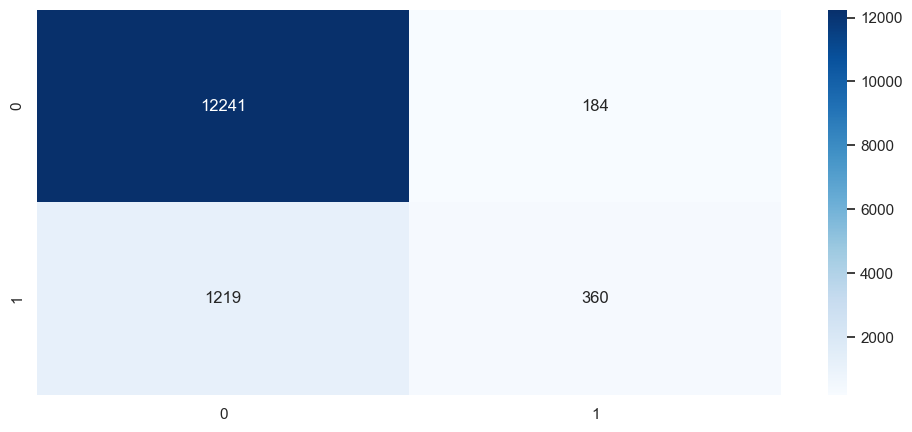

Number of nodes: 145
Number of leaves: 73
Tree depth: 13


In [8]:
# Create the model
model = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(
        min_samples_leaf=272,
        max_depth=None,
        ccp_alpha=0.0
    )
)

# Fit the model
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions for the test set
y_test_pred = model.predict(X_test)

# Calculate the confusion matrix for the test set
print("\nConfusion Matrix (Test Data):")
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.show()


tree = model[-1]  # Get the tree from pipeline

# Print tree statistics
print(f"Number of nodes: {tree.tree_.node_count}")
print(f"Number of leaves: {tree.get_n_leaves()}")
print(f"Tree depth: {tree.get_depth()}")

# Get feature names after preprocessing
numeric_features = numeric_selector(X)
categorical_features = categorical_selector(X)
feature_names = numeric_features + [f"{feat}_{val}" for feat in categorical_features 
                                  for val in df[feat].unique()[1:]]

# Exercise 4: limiting path length

Test Accuracy: 0.8997

Confusion Matrix (Test Data):


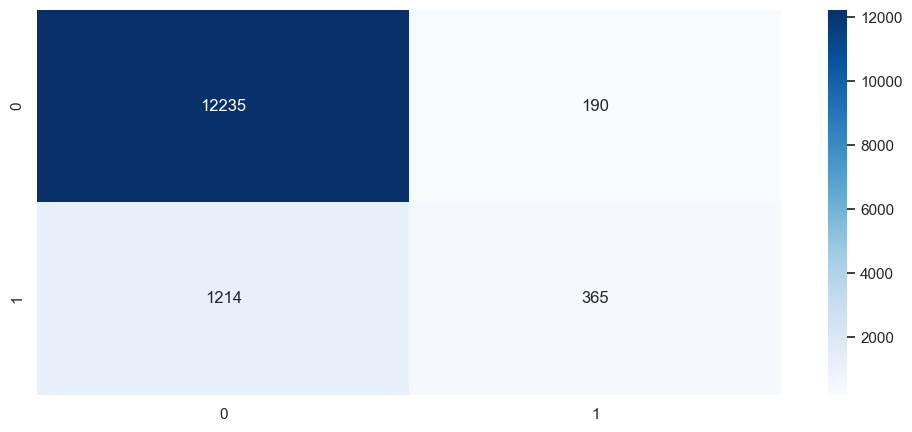

Number of nodes: 63
Number of leaves: 32
Tree depth: 5


In [9]:
# Create the model
model = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(
        min_samples_leaf=1,
        max_depth=5,
        ccp_alpha=0.0
    )
)

# Fit the model
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions for the test set
y_test_pred = model.predict(X_test)

# Calculate the confusion matrix for the test set
print("\nConfusion Matrix (Test Data):")
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.show()


tree = model[-1]  # Get the tree from pipeline

# Print tree statistics
print(f"Number of nodes: {tree.tree_.node_count}")
print(f"Number of leaves: {tree.get_n_leaves()}")
print(f"Tree depth: {tree.get_depth()}")

# Get feature names after preprocessing
numeric_features = numeric_selector(X)
categorical_features = categorical_selector(X)
feature_names = numeric_features + [f"{feat}_{val}" for feat in categorical_features 
                                  for val in df[feat].unique()[1:]]

# Exercise 5: significance test

Another way to limit the size of the classification tree is to stop splitting/growing the tree if the next
split of a leaf adds very little to the purity of its following leaves. Weka implemented this by looking at
the variance between the subgroups. We could try many iterations about what this threshold level of
minimum variance should be, but for now assume it is 0.1. Run the following model:
- First set the dependent variable: (Nom) outcome
- Choose: select Weka >> classifiers >> trees >> REPTree
Click on the text “REPTree” to change its settings:
maxDepth: return to -1
minNum: keep at 1.0
Strategy Analytics Tutorial 3 © Martin C. Goossen/ Peter Snoeren
minVarianceProp: change to 0.1
noPruning: keep at True
(leave all other settings to their default value)
Click OK
- Test options: Percentage split with 66%
- Press Start.
5a) What is the percentage of correctly classified cases?
5b) What is the size of the decision tree?

Test Accuracy: 0.8872

Confusion Matrix (Test Data):


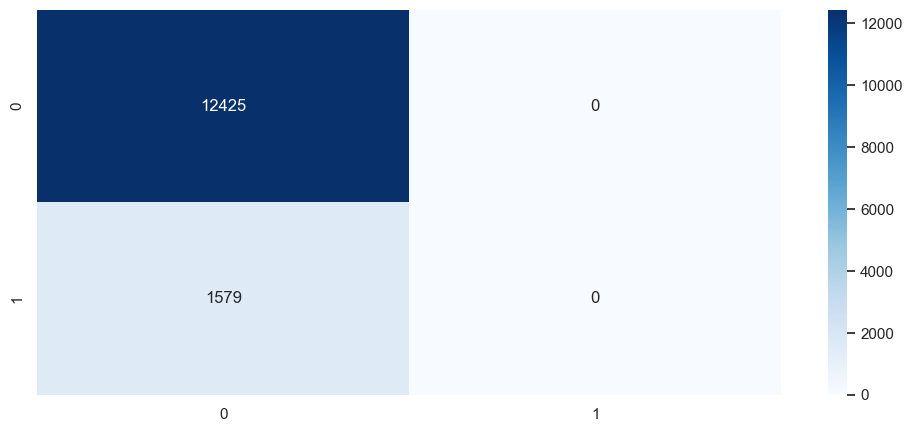

Number of nodes: 1
Number of leaves: 1
Tree depth: 0


In [10]:
# Create the model
model = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(
        min_samples_leaf=1,
        max_depth=None,
        min_impurity_decrease=0.1,  # Similar to minVarianceProp: 0.1
        ccp_alpha=0.0
    )
)

# Fit the model
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions for the test set
y_test_pred = model.predict(X_test)

# Calculate the confusion matrix for the test set
print("\nConfusion Matrix (Test Data):")
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.show()


tree = model[-1]  # Get the tree from pipeline

# Print tree statistics
print(f"Number of nodes: {tree.tree_.node_count}")
print(f"Number of leaves: {tree.get_n_leaves()}")
print(f"Tree depth: {tree.get_depth()}")

# Get feature names after preprocessing
numeric_features = numeric_selector(X)
categorical_features = categorical_selector(X)
feature_names = numeric_features + [f"{feat}_{val}" for feat in categorical_features 
                                  for val in df[feat].unique()[1:]]

# Exercise 6: pruning

Test Accuracy: 0.8872

Confusion Matrix (Test Data):


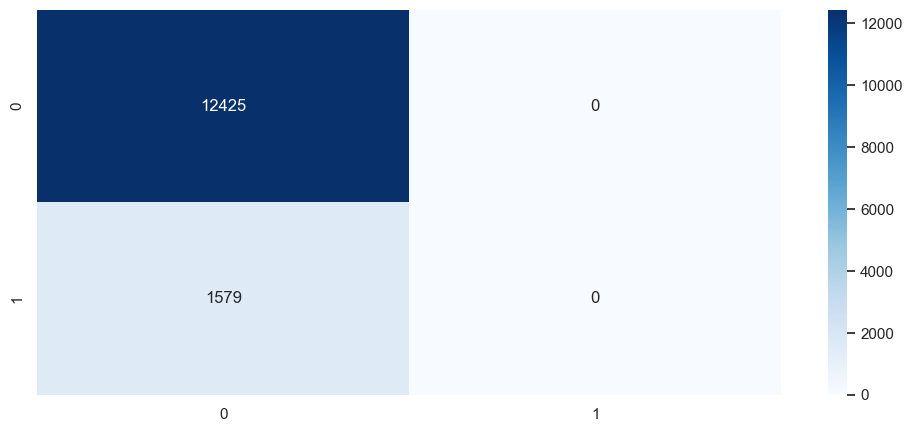

Number of nodes: 1
Number of leaves: 1
Tree depth: 0


In [11]:
# Create the model
model = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(
        min_samples_leaf=1,
        max_depth=None,
        min_impurity_decrease=0.1,  # Similar to minVarianceProp: 0.1
        ccp_alpha=0.001
    )
)

# Fit the model
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions for the test set
y_test_pred = model.predict(X_test)

# Calculate the confusion matrix for the test set
print("\nConfusion Matrix (Test Data):")
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.show()


tree = model[-1]  # Get the tree from pipeline

# Print tree statistics
print(f"Number of nodes: {tree.tree_.node_count}")
print(f"Number of leaves: {tree.get_n_leaves()}")
print(f"Tree depth: {tree.get_depth()}")

# Get feature names after preprocessing
numeric_features = numeric_selector(X)
categorical_features = categorical_selector(X)
feature_names = numeric_features + [f"{feat}_{val}" for feat in categorical_features 
                                  for val in df[feat].unique()[1:]]

# Exercise 7: sweet spot

# Exercise 8: random forest

‘Ensemble methods’ create multiple classification trees to reduce overfitting. One method is ‘random
forest’ where subsets of all variables are used to create separate trees. To see the accuracy of this
classifier, run the following model:
Strategy Analytics Tutorial 3 © Martin C. Goossen/ Peter Snoeren
- First set the dependent variable: (Nom) outcome
- Choose: select Weka >> classifiers >> trees >> RandomForest
(leave all RandomForest settings to their default value)
- Test options: Percentage split with 66%
- Press Start and wait.
8) What is the percentage of correctly classified cases?

Test Accuracy: 0.8890


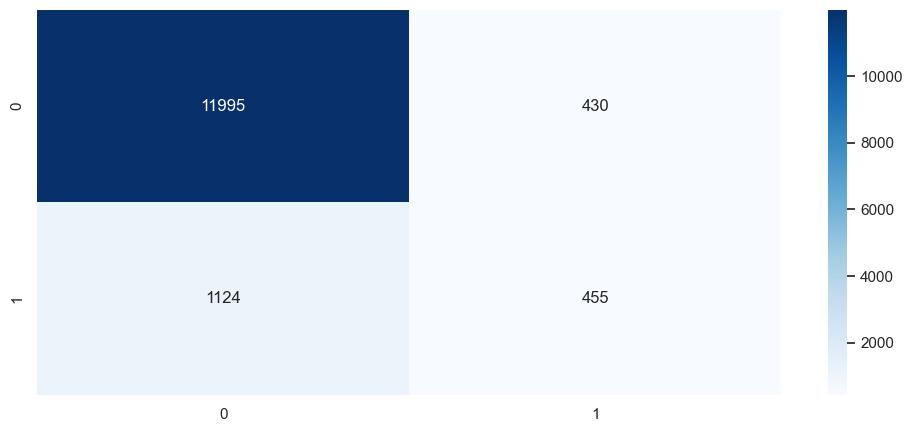

In [12]:
# Create the model
model = make_pipeline(
    preprocessor,
    RandomForestClassifier(
        n_estimators=100,  # Default number of trees
        random_state=42
    )
)

# Fit and evaluate
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion matrix
y_test_pred = model.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.show()

# Exercise 9: bagging

Test Accuracy: 0.8897

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12425
           1       0.52      0.29      0.37      1579

    accuracy                           0.89     14004
   macro avg       0.72      0.63      0.66     14004
weighted avg       0.87      0.89      0.88     14004



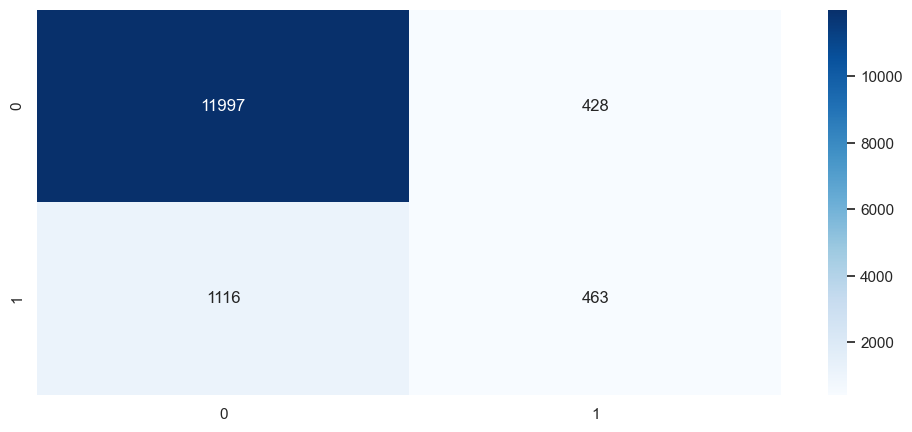

In [13]:

# Create bagging model with decision tree base estimator
model = make_pipeline(
    preprocessor,
    BaggingClassifier(
        estimator=DecisionTreeClassifier(min_samples_leaf=2),  # Similar to J48
        n_estimators=10,  # Weka's default
        random_state=42
    )
)

# Fit and evaluate
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_test_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.show()

# Exercise 10: boosting

Test Accuracy: 0.8760

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     12425
           1       0.43      0.29      0.35      1579

    accuracy                           0.88     14004
   macro avg       0.67      0.62      0.64     14004
weighted avg       0.86      0.88      0.87     14004



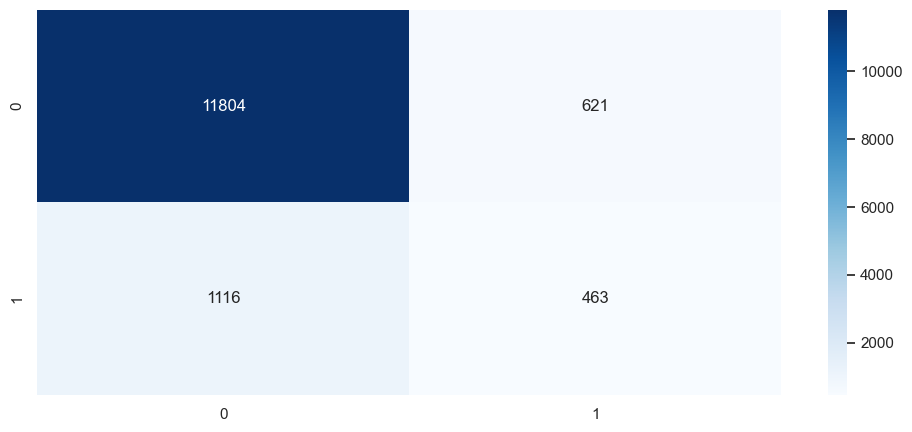

In [14]:
from sklearn.ensemble import AdaBoostClassifier

# Create AdaBoost model with decision tree base estimator
model = make_pipeline(
    preprocessor,
    AdaBoostClassifier(
        estimator=DecisionTreeClassifier(min_samples_leaf=2),  # Similar to J48
        n_estimators=10,  # Weka's default
        learning_rate=1.0,  # Default learning rate
        random_state=42
    )
)

# Fit and evaluate
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_test_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.show()

# Part 2: Clustering

## Exercise 12

In [15]:
wines_subset = pd.read_csv("./Data/Part 2 - WinesSubset.csv")

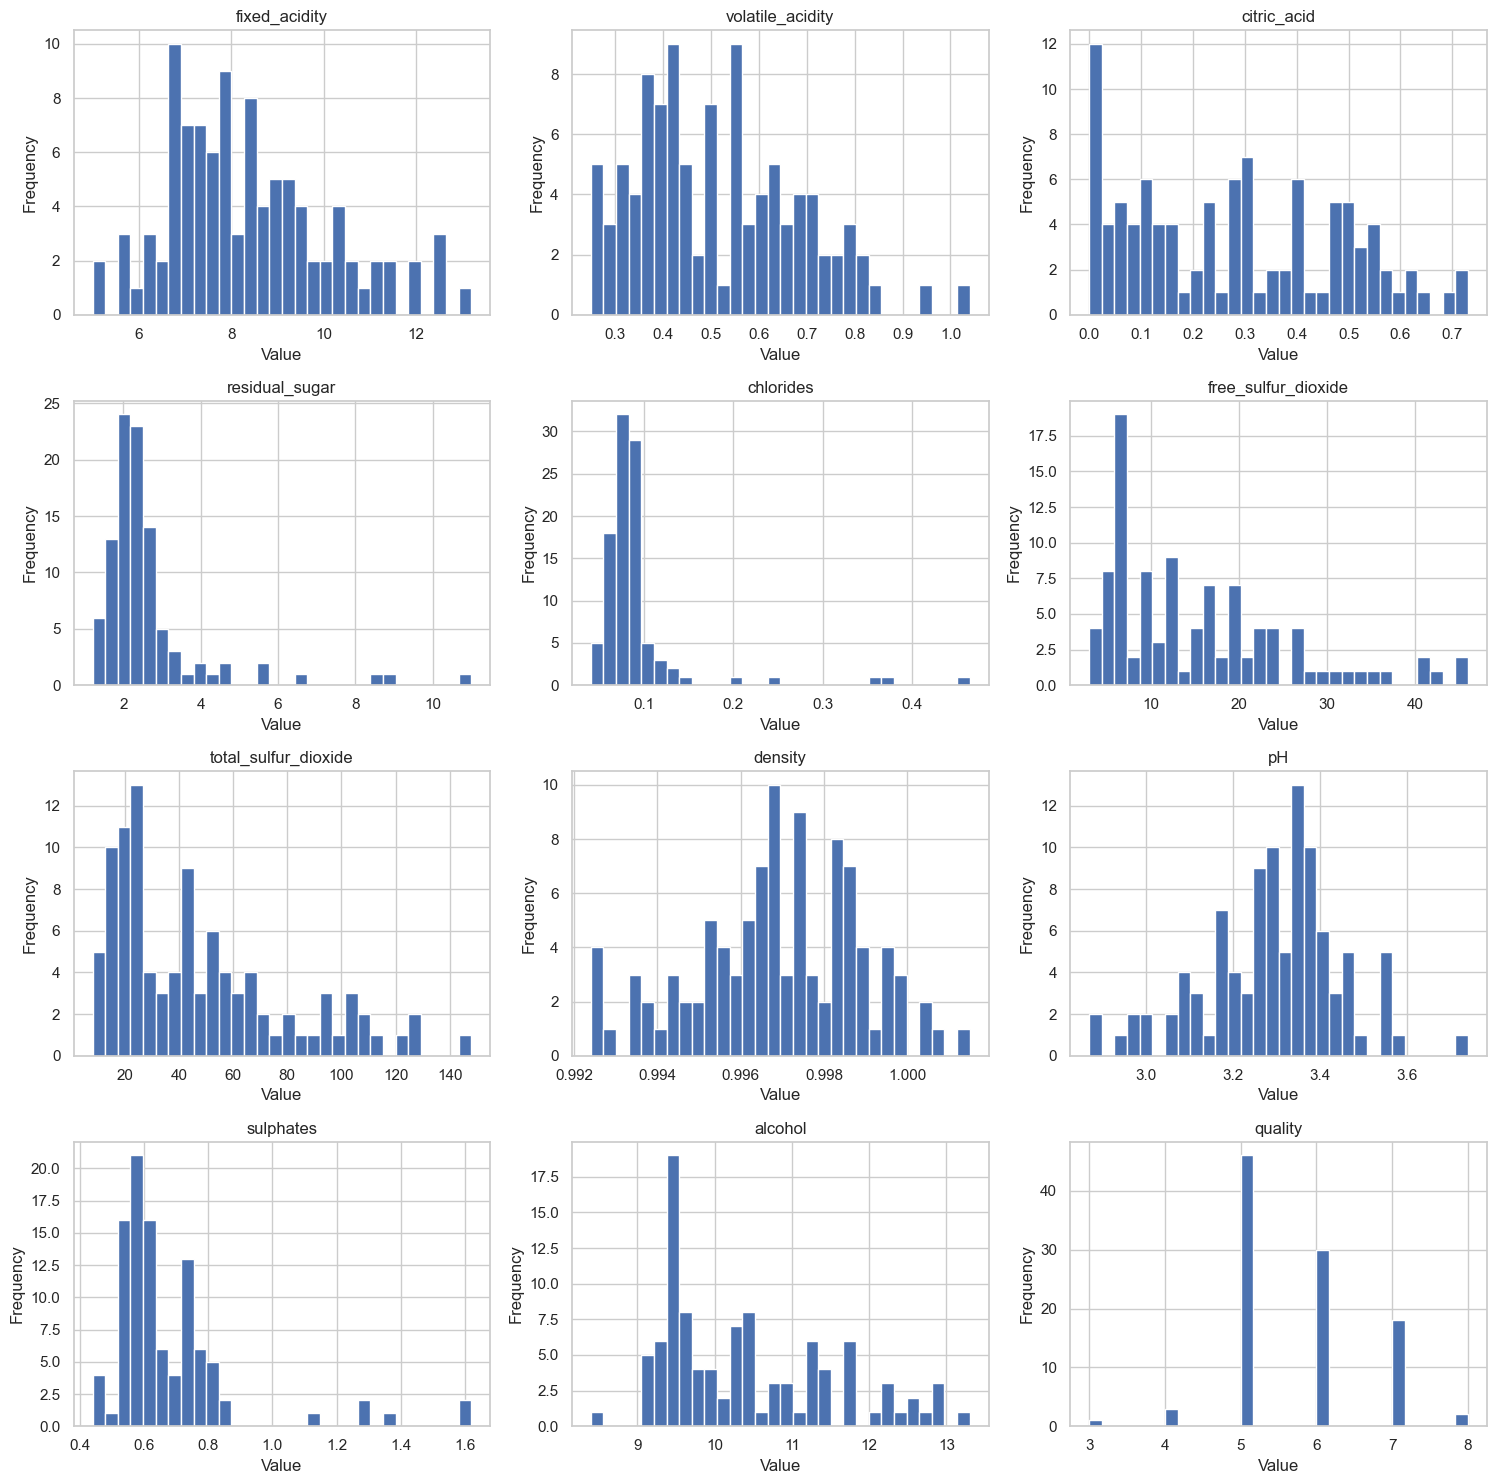

In [16]:
# Create histograms for all variables
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.ravel()

for idx, col in enumerate(wines_subset.columns[:-1]):

    axes[idx].hist(wines_subset[col], bins=30)
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


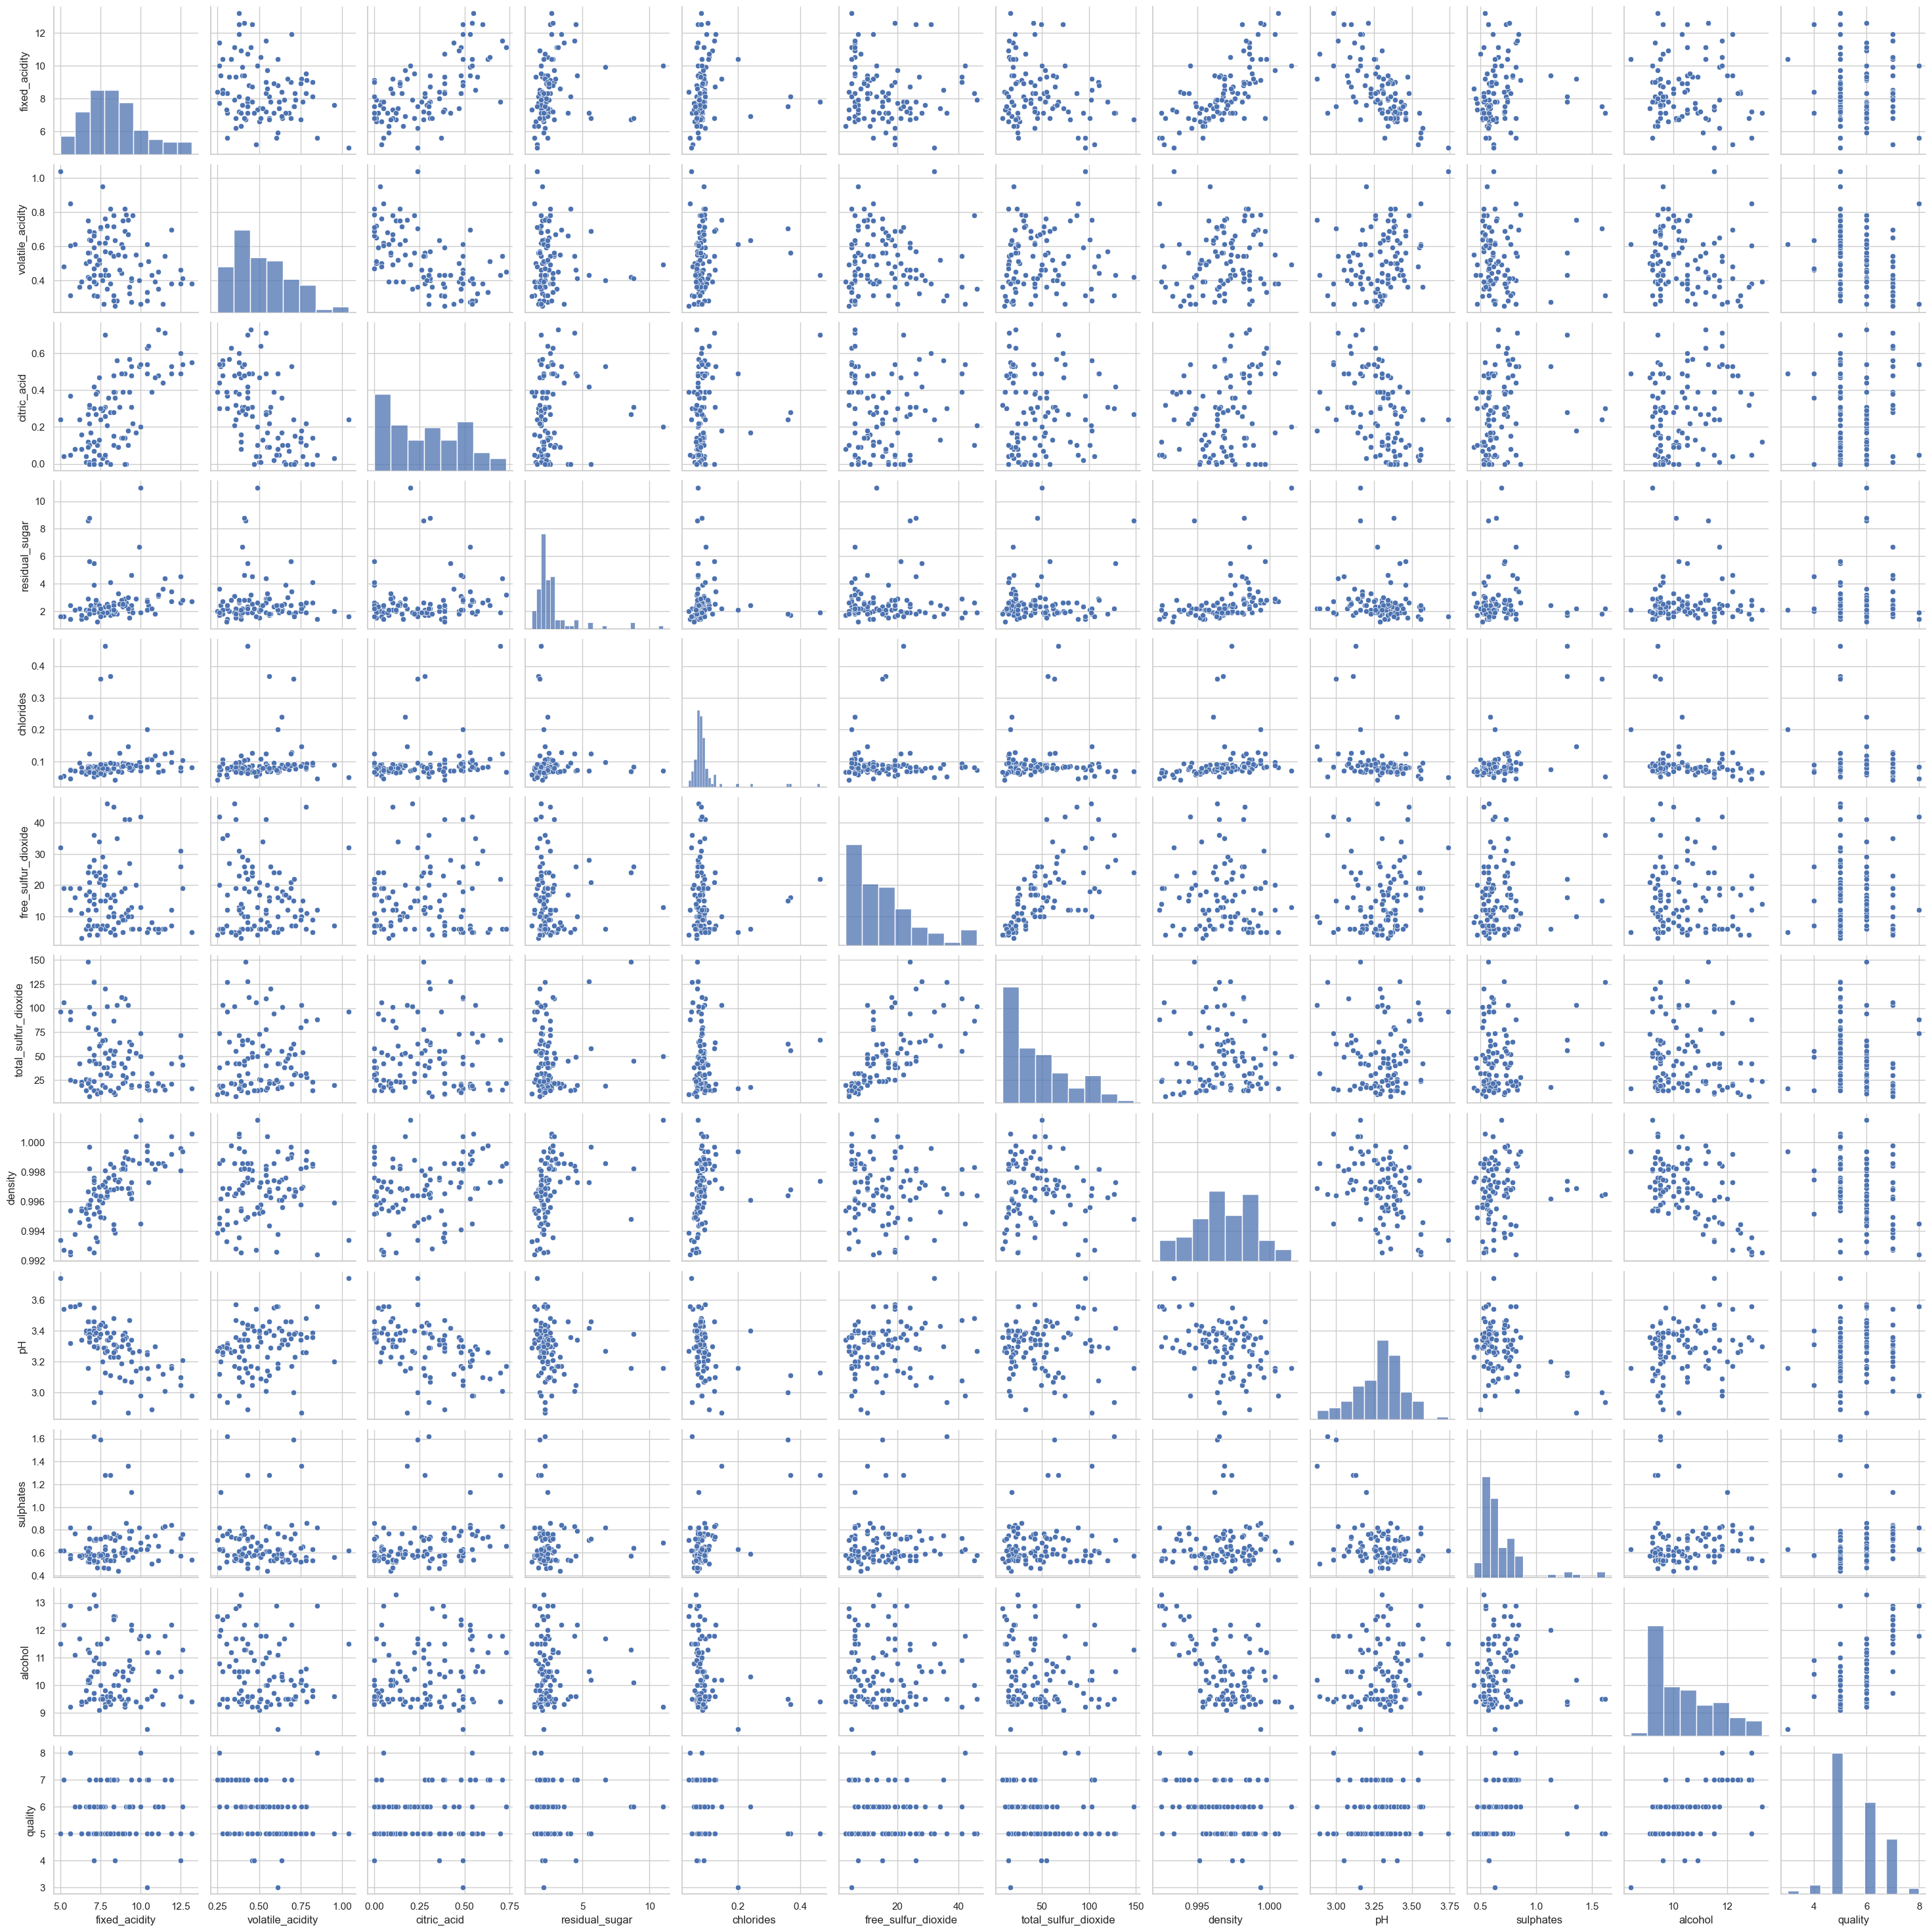

In [17]:
# Create scatterplots for all pairs of variables
sns.pairplot(wines_subset.drop(columns=['red']))
plt.show()


# Part 3: KNN

In [17]:
df3 = pd.read_csv("./Data/Part 3 - Churn.csv")

In [18]:
# Get columns where 'top' row is not NaN
df3.describe(include='all')

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,2,2,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,2
top,Male,No,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,3555,5901,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


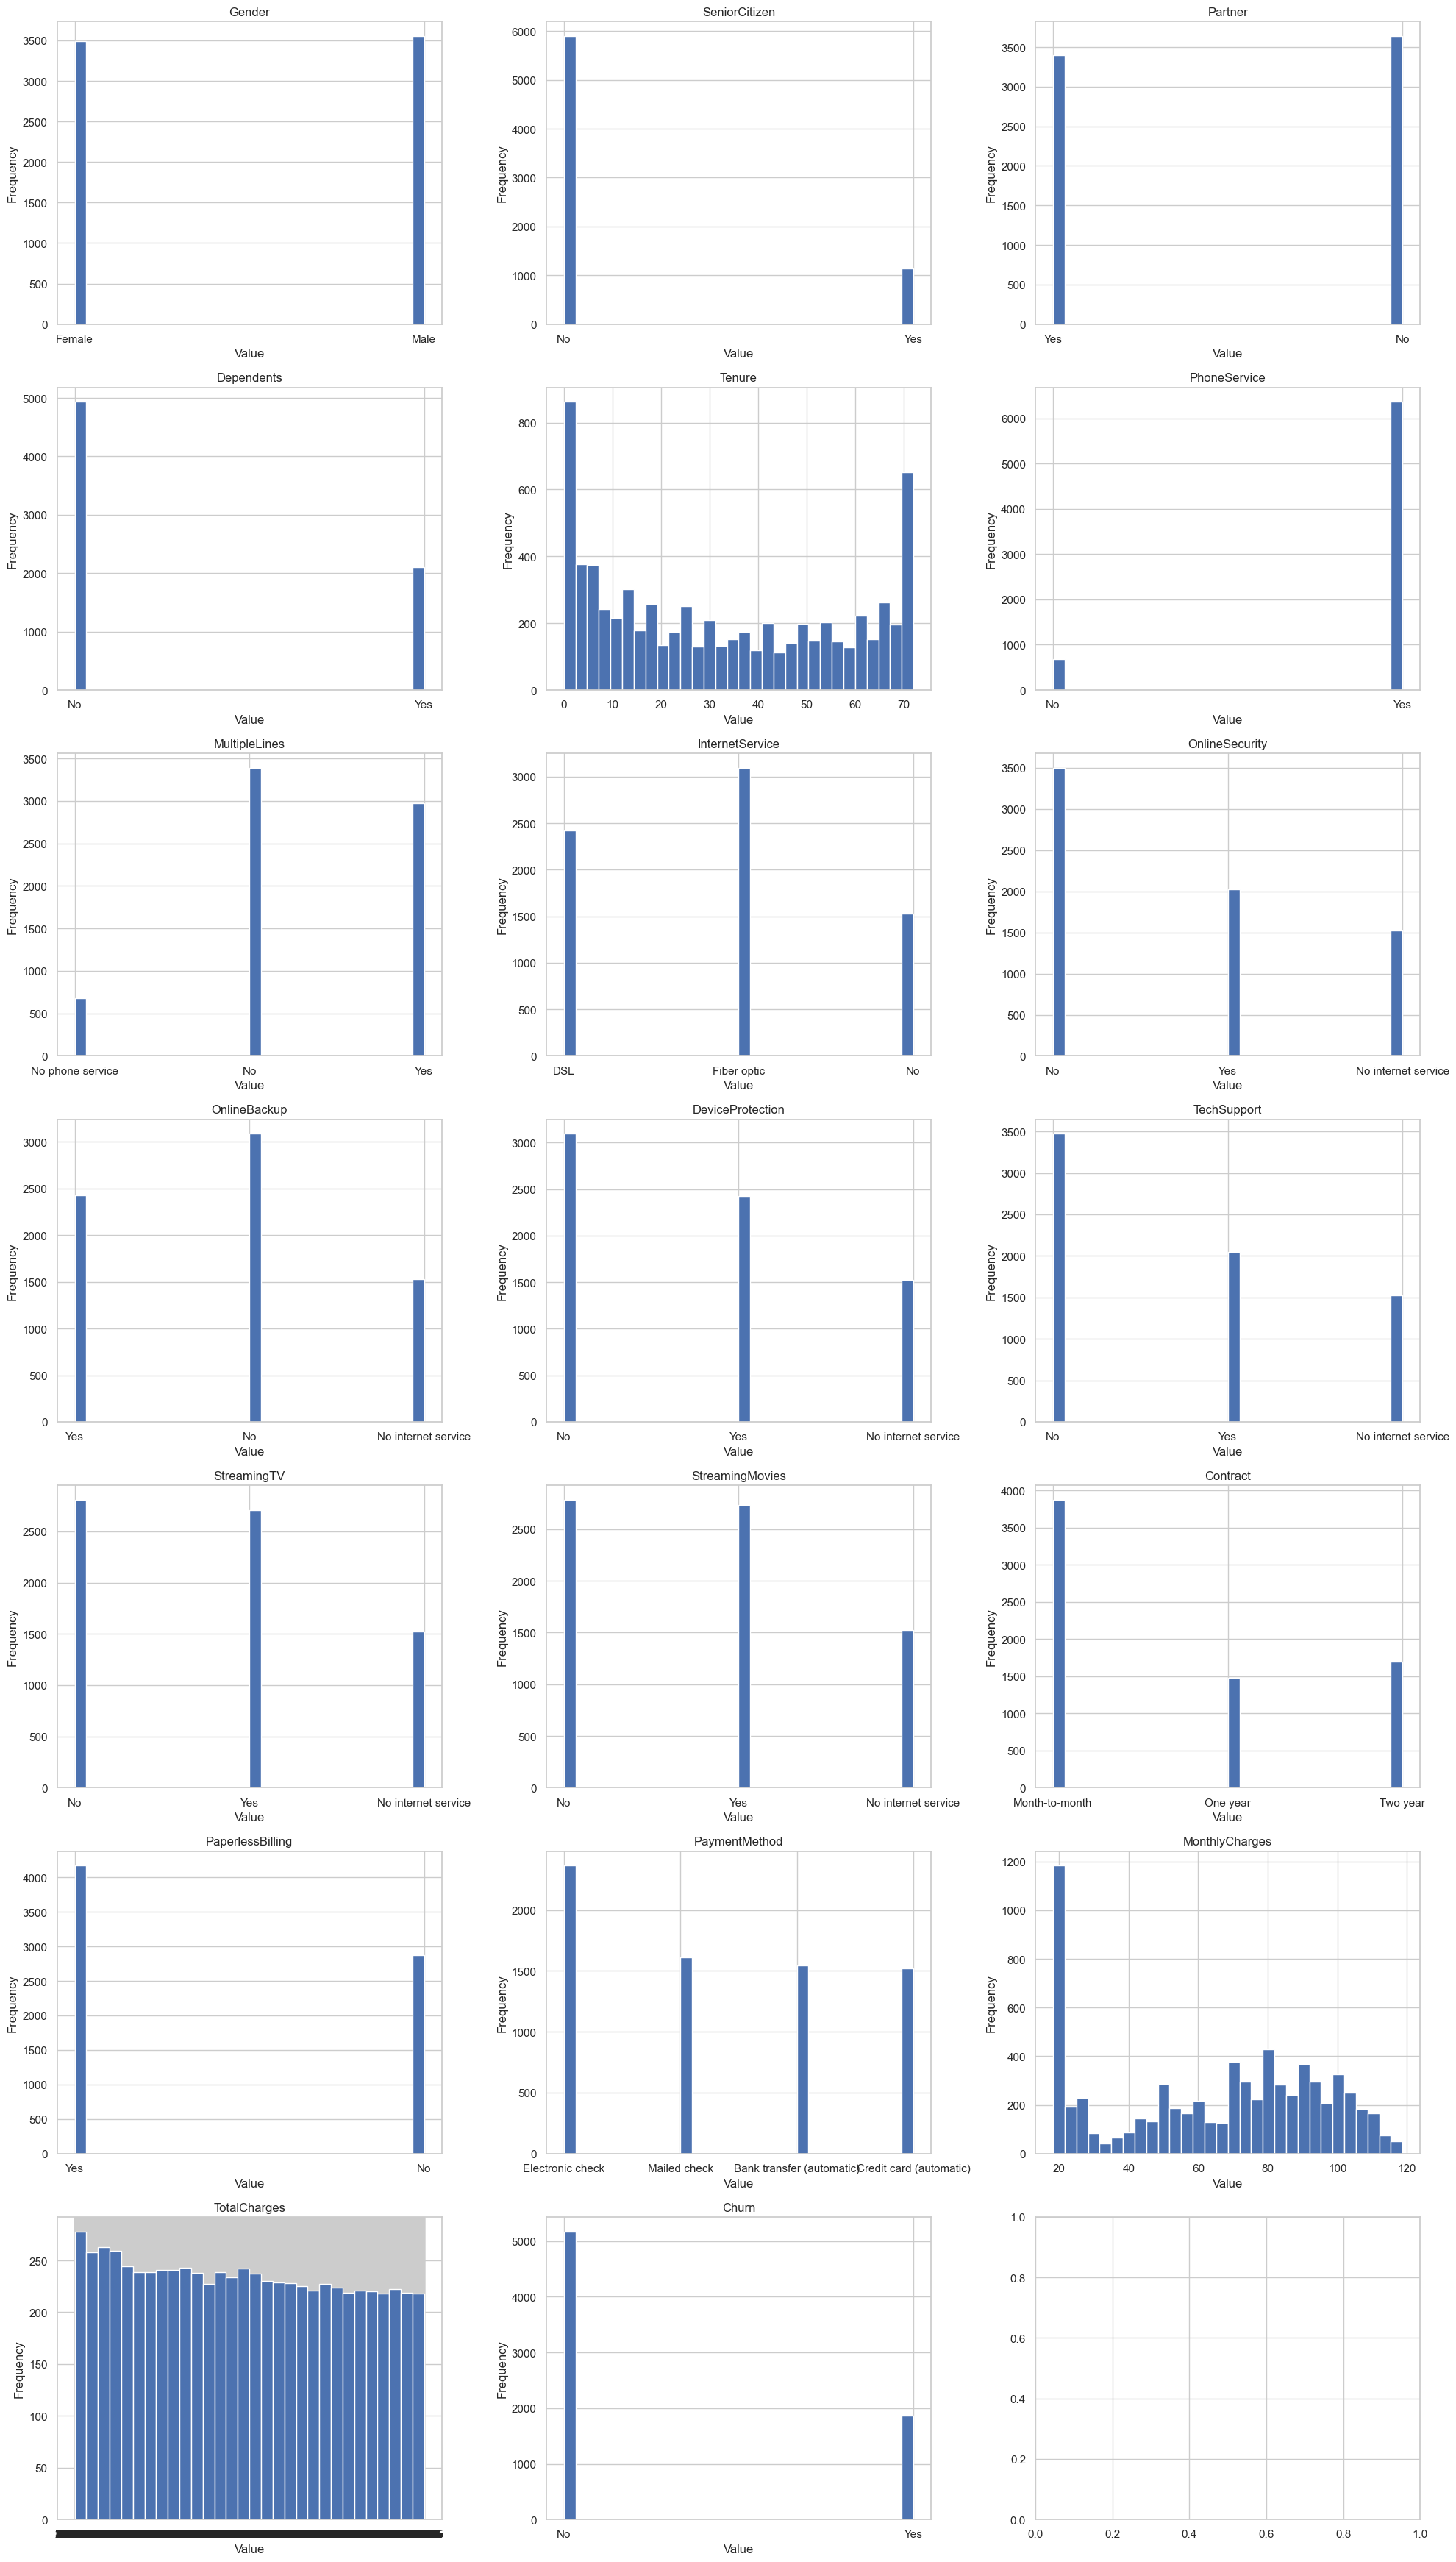

In [19]:
# Create histograms for all variables
n_features = len(df3.columns)
n_cols = 3
n_rows = -(-n_features // n_cols)

# Create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.ravel()

for idx, col in enumerate(df3.columns):

    axes[idx].hist(df3[col], bins=30)
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Exercise 22: kNN

In [49]:
def evaluate_knn_model(df, target_col='Churn', n_neighbors=1, cv=10):
    start_time = time.time()
    numeric_selector = make_column_selector(dtype_include=['int64', 'float64'])
    categorical_selector = make_column_selector(dtype_include=['object', 'category'])


    # Clean and prepare the data first
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Convert TotalCharges to numeric, handling any invalid values
    X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
    X['TotalCharges'].fillna(X['TotalCharges'].mean(), inplace=True)

    # Create preprocessor
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_selector),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_selector)
    ])

    # Create and evaluate model
    model = make_pipeline(
        preprocessor,
        KNeighborsClassifier(n_neighbors=n_neighbors)
    )
    # Perform cross validation
    scores = cross_val_score(model, X, y, cv=cv)
    mean_accuracy = scores.mean()
    std_accuracy = scores.std()
    processing_time = time.time() - start_time
    return {
        'neighbors': n_neighbors,
        'cv_folds': cv,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'processing_time': processing_time
    }


In [57]:
for n in [1, 2, 3, 5, 10, 15, 25, 50, 75, 100, 1000, 5000, 6000]:
    print(pd.DataFrame(evaluate_knn_model(df3, n_neighbors=n), index=[0]))

   neighbors  cv_folds  mean_accuracy  std_accuracy  processing_time
0          1        10       0.728662      0.020451         0.409077
   neighbors  cv_folds  mean_accuracy  std_accuracy  processing_time
0          2        10        0.75749      0.014451         0.398922
   neighbors  cv_folds  mean_accuracy  std_accuracy  processing_time
0          3        10       0.757487      0.018172         0.396576
   neighbors  cv_folds  mean_accuracy  std_accuracy  processing_time
0          5        10        0.76672      0.018238          0.39844
   neighbors  cv_folds  mean_accuracy  std_accuracy  processing_time
0         10        10       0.785458      0.014693         0.403308
   neighbors  cv_folds  mean_accuracy  std_accuracy  processing_time
0         15        10       0.787731      0.014332         0.418074
   neighbors  cv_folds  mean_accuracy  std_accuracy  processing_time
0         25        10       0.795964      0.013363         0.432203
   neighbors  cv_folds  mean_accur

In [ ]:
from sklearn.svm import SVC

def compare_models(df, cv=5):
    # Prepare data
    X = df.drop('Churn', axis=1)
    y = df['Churn']
    X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
    X['TotalCharges'].fillna(X['TotalCharges'].mean(), inplace=True)
    
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), make_column_selector(dtype_include=['int64', 'float64'])),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), make_column_selector(dtype_include=['object']))
    ])
    
    # Define base models
    base_models = {
        'Logistic': LogisticRegression(),
        'Tree': DecisionTreeClassifier(min_samples_leaf=2),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(kernel='rbf')  # Added SVM with RBF kernel
    }
    
    results = {}
    
    for name, model in base_models.items():
        scores = {'Ordinary': 0.0, 'Bagged': 0.0, 'Boosted': 0.0}
        
        # Ordinary
        pipe = make_pipeline(preprocessor, model)
        scores['Ordinary'] = cross_val_score(pipe, X, y, cv=cv).mean()
        
        # Bagged
        pipe_bagged = make_pipeline(preprocessor, BaggingClassifier(model, n_estimators=10))
        scores['Bagged'] = cross_val_score(pipe_bagged, X, y, cv=cv).mean()
        
        # Boosted (only for models that support sample weights)
        if name not in ['KNN', 'SVM']:  # SVM also doesn't support sample weights in sklearn
            pipe_boosted = make_pipeline(preprocessor, AdaBoostClassifier(model, n_estimators=10))
            scores['Boosted'] = cross_val_score(pipe_boosted, X, y, cv=cv).mean()
        else:
            scores['Boosted'] = None
            
        results[name] = scores
    
    return pd.DataFrame(results).T.round(4)


results = compare_models(df3)
print(results)

          Ordinary  Bagged  Boosted
Logistic    0.8039  0.8039   0.7789
Tree        0.7386  0.7747   0.7759
KNN         0.7677  0.7734      NaN
SVM         0.8024  0.8029      NaN
